In [2]:
import database_connection as db
import argparse
import pandas as pd 
from os import path
import text_preprocess
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk
from nltk.stem import WordNetLemmatizer
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
from evaluator import evaluate
from datetime import datetime
import sentiment_analysis

In [3]:
in_file = 'sentiment_annotations.csv'
data_in_file = pd.read_csv(in_file, sep=',', keep_default_na=False)

In [4]:
data = sentiment_analysis.getDataFromDB()

In [5]:
# For now, combine title and entry as 1 feature.
# TODO: evaluate perf of each.
concatenation = data['title'] + ' ' + data['entry']

In [6]:
# Original Results from .csv File
start_time = datetime.now()
print(f'{datetime.now().strftime("%H:%M:%S.%f")}: Evaluating the accuracy metrics.')
og_metrics = evaluate(data_in_file['annotated_sentiment'], data_in_file['sentiment_output'])
end_time = datetime.now()
print(f'{datetime.now().strftime("%H:%M:%S.%f")}: Total runtime: {end_time - start_time }')

19:18:50.890396: Evaluating the accuracy metrics.
Confusion Matrix:
[[105  28   0]
 [ 51  49  10]
 [  2   2  53]]

Classification Report:
	*Ignore F1-Score since this is multiclass.
              precision    recall  f1-score   support

    NEGATIVE      0.665     0.789     0.722       133
     NEUTRAL      0.620     0.445     0.519       110
    POSITIVE      0.841     0.930     0.883        57

    accuracy                          0.690       300
   macro avg      0.709     0.722     0.708       300
weighted avg      0.682     0.690     0.678       300


Individualized metrics:
accuracy: 0.69
precision: [0.66455696 0.62025316 0.84126984]
recall: [0.78947368 0.44545455 0.92982456]
19:18:50.907018: Total runtime: 0:00:00.016619


In [7]:
# Method: TextBlob, concatenating title and entry
start_time = datetime.now()
# PreProcess the text
print(f'{datetime.now().strftime("%H:%M:%S.%f")}: Preprocessing the data.')
processed = concatenation.apply(text_preprocess.preprocessText)
print(f'{datetime.now().strftime("%H:%M:%S.%f")}: Finished preprocessing the data.')
print(f'{datetime.now().strftime("%H:%M:%S.%f")}: Calculating predictions with the TextBlob statistical method.')        
polarity = processed.apply(sentiment_analysis.getPolarity)
print(f'{datetime.now().strftime("%H:%M:%S.%f")}: Finished calculating predictions.')
print(f'{datetime.now().strftime("%H:%M:%S.%f")}: Analyzing the scores.')
sentiment_output = polarity.apply(sentiment_analysis.lowThresholdAnalysis)
print(f'{datetime.now().strftime("%H:%M:%S.%f")}: Finished analyzing the scores.')
print(f'{datetime.now().strftime("%H:%M:%S.%f")}: Evaluating the accuracy metrics.')
textblob_metrics = evaluate(data['annotated_sentiment'], sentiment_output)
end_time = datetime.now()
print(f'{datetime.now().strftime("%H:%M:%S.%f")}: Total runtime: {end_time - start_time }')

19:18:50.913480: Preprocessing the data.
19:18:53.266147: Finished preprocessing the data.
19:18:53.266252: Calculating predictions with the TextBlob statistical method.
19:18:53.332936: Finished calculating predictions.
19:18:53.332975: Analyzing the scores.
19:18:53.333152: Finished analyzing the scores.
19:18:53.333172: Evaluating the accuracy metrics.
Confusion Matrix:
[[ 11 134  13]
 [  2  68   9]
 [  0  18  45]]

Classification Report:
	*Ignore F1-Score since this is multiclass.
              precision    recall  f1-score   support

    NEGATIVE      0.846     0.070     0.129       158
     NEUTRAL      0.309     0.861     0.455        79
    POSITIVE      0.672     0.714     0.692        63

    accuracy                          0.413       300
   macro avg      0.609     0.548     0.425       300
weighted avg      0.668     0.413     0.333       300


Individualized metrics:
accuracy: 0.41333333333333333
precision: [0.84615385 0.30909091 0.67164179]
recall: [0.06962025 0.860759

In [8]:
# Vader: Valence Aware Dictionary and Sentiment Reasoner
start_time = datetime.now()
print(f'{datetime.now().strftime("%H:%M:%S.%f")}: Preprocessing the data.')
processed = concatenation.apply(text_preprocess.preprocessText)
print(f'{datetime.now().strftime("%H:%M:%S.%f")}: Finished preprocessing the data.')
print(f'{datetime.now().strftime("%H:%M:%S.%f")}: Calculating predictions with the Vader statistical method.')  
scores = processed.apply(sentiment_analysis.getVaderSentiment)
print(f'{datetime.now().strftime("%H:%M:%S.%f")}: Finished calculating predictions.')
print(f'{datetime.now().strftime("%H:%M:%S.%f")}: Analyzing the scores.')
sentiment_output = scores.apply(sentiment_analysis.highThresholdAnalysis)
print(f'{datetime.now().strftime("%H:%M:%S.%f")}: Finished analyzing the scores.')
print(f'{datetime.now().strftime("%H:%M:%S.%f")}: Evaluating the accuracy metrics.')
vader_metrics = evaluate(data['annotated_sentiment'], sentiment_output)
end_time = datetime.now()
print(f'{datetime.now().strftime("%H:%M:%S.%f")}: Total runtime: {end_time - start_time }')

19:18:53.343772: Preprocessing the data.
19:18:54.971345: Finished preprocessing the data.
19:18:54.971450: Calculating predictions with the Vader statistical method.
19:18:56.409766: Finished calculating predictions.
19:18:56.409871: Analyzing the scores.
19:18:56.410077: Finished analyzing the scores.
19:18:56.410098: Evaluating the accuracy metrics.
Confusion Matrix:
[[37 79 42]
 [ 8 37 34]
 [ 0 16 47]]

Classification Report:
	*Ignore F1-Score since this is multiclass.
              precision    recall  f1-score   support

    NEGATIVE      0.822     0.234     0.365       158
     NEUTRAL      0.280     0.468     0.351        79
    POSITIVE      0.382     0.746     0.505        63

    accuracy                          0.403       300
   macro avg      0.495     0.483     0.407       300
weighted avg      0.587     0.403     0.390       300


Individualized metrics:
accuracy: 0.4033333333333333
precision: [0.82222222 0.28030303 0.38211382]
recall: [0.23417722 0.46835443 0.74603175

In [11]:
# HuggingFace sentiment analysis pipeline with RoBERTa twitter model
start_time = datetime.now()

print(f'{datetime.now().strftime("%H:%M:%S.%f")}: Preprocessing the data.')
preprocessed = concatenation.apply(sentiment_analysis.preprocess)
print(f'{datetime.now().strftime("%H:%M:%S.%f")}: Finished preprocessing the data.')
print(f'{datetime.now().strftime("%H:%M:%S.%f")}: Calculating predictions with the Roberta Twitter model.')

# using autotokenizer pretrained on same model as used instead of my custom preprocessing
# processed = concatenation.apply(text_preprocess.preprocessText)

# Use tokenizer from base model, not task model.
# RoBERTa's max token length is 512.
tokenizer = AutoTokenizer.from_pretrained('cardiffnlp/twitter-roberta-base')

# PyTorch
# TODO: consider tuning classifier model hyperparams: hidden_states, attentions
model='cardiffnlp/twitter-roberta-base-sentiment'
task='sentiment'
"""
# Valid tasks for this model:
# emoji, emotion, hate, irony, offensive, sentiment
# stance/abortion, stance/atheism, stance/climate, stance/feminist, stance/hillary
"""

classifier = AutoModelForSequenceClassification.from_pretrained(model)

scores_series = preprocessed.apply(sentiment_analysis.getRobertaScore, args=(model, tokenizer, classifier))
print(f'{datetime.now().strftime("%H:%M:%S.%f")}: Finished calculating predictions.')
print(f'{datetime.now().strftime("%H:%M:%S.%f")}: Analyzing the scores.')
sentiment_output = scores_series.apply(sentiment_analysis.robertaScoresAnalysis)
print(f'{datetime.now().strftime("%H:%M:%S.%f")}: Finished analyzing the scores.')

print(f'{datetime.now().strftime("%H:%M:%S.%f")}: Evaluating the accuracy metrics.')
hf_roberta_metrics = evaluate(data['annotated_sentiment'], sentiment_output)
end_time = datetime.now()
print(f'{datetime.now().strftime("%H:%M:%S.%f")}: Total runtime: {end_time - start_time }')

17:26:35.209837: Preprocessing the data.
17:26:35.223722: Finished preprocessing the data.
17:26:35.223813: Calculating predictions with the Roberta Twitter model.
17:29:11.852828: Finished calculating predictions.
17:29:11.852951: Analyzing the scores.
17:29:11.853725: Finished analyzing the scores.
17:29:11.853747: Evaluating the accuracy metrics.
Confusion Matrix:
[[113  40   5]
 [ 26  42  11]
 [  0   5  58]]

Classification Report:
	*Ignore F1-Score since this is multiclass.
              precision    recall  f1-score   support

    NEGATIVE      0.813     0.715     0.761       158
     NEUTRAL      0.483     0.532     0.506        79
    POSITIVE      0.784     0.921     0.847        63

    accuracy                          0.710       300
   macro avg      0.693     0.722     0.705       300
weighted avg      0.720     0.710     0.712       300


Individualized metrics:
accuracy: 0.71
precision: [0.81294964 0.48275862 0.78378378]
recall: [0.71518987 0.53164557 0.92063492]
Confus

In [44]:
# HuggingFace sentiment analysis pipeline with RoBERTa twitter model
# There is a difference in evaluation between the database and the CSV file. 
# These are results against the CSV file.
start_time = datetime.now()
concatenation = data_in_file['title'] + ' ' + data_in_file['entry']

print(f'{datetime.now().strftime("%H:%M:%S.%f")}: Preprocessing the data.')
preprocessed = concatenation.apply(sentiment_analysis.preprocess)
print(f'{datetime.now().strftime("%H:%M:%S.%f")}: Finished preprocessing the data.')
print(f'{datetime.now().strftime("%H:%M:%S.%f")}: Calculating predictions with the Roberta Twitter model against the .csv file.')

# using autotokenizer pretrained on same model as used instead of my custom preprocessing
# processed = concatenation.apply(text_preprocess.preprocessText)

# Use tokenizer from base model, not task model.
# RoBERTa's max token length is 512.
tokenizer = AutoTokenizer.from_pretrained('cardiffnlp/twitter-roberta-base')

# PyTorch
# TODO: consider tuning classifier model hyperparams: hidden_states, attentions
model='cardiffnlp/twitter-roberta-base-sentiment'
task='sentiment'
"""
# Valid tasks for this model:
# emoji, emotion, hate, irony, offensive, sentiment
# stance/abortion, stance/atheism, stance/climate, stance/feminist, stance/hillary
"""

classifier = AutoModelForSequenceClassification.from_pretrained(model)

scores_series = preprocessed.apply(sentiment_analysis.getRobertaScore, args=(model, tokenizer, classifier))
print(f'{datetime.now().strftime("%H:%M:%S.%f")}: Finished calculating predictions.')
print(f'{datetime.now().strftime("%H:%M:%S.%f")}: Analyzing the scores.')
sentiment_output = scores_series.apply(sentiment_analysis.robertaScoresAnalysis)
print(f'{datetime.now().strftime("%H:%M:%S.%f")}: Finished analyzing the scores.')

print(f'{datetime.now().strftime("%H:%M:%S.%f")}: Evaluating the accuracy metrics.')
hf_roberta_metrics = evaluate(data_in_file['annotated_sentiment'], sentiment_output)
end_time = datetime.now()
print(f'{datetime.now().strftime("%H:%M:%S.%f")}: Total runtime: {end_time - start_time }')

18:34:47.195394: Preprocessing the data.
18:34:47.205984: Finished preprocessing the data.
18:34:47.206051: Calculating predictions with the Roberta Twitter model against the .csv file.
18:37:21.464121: Finished calculating predictions.
18:37:21.464321: Analyzing the scores.
18:37:21.465230: Finished analyzing the scores.
18:37:21.465273: Evaluating the accuracy metrics.
Confusion Matrix:
[[104  26   3]
 [ 35  58  17]
 [  0   3  54]]

Classification Report:
	*Ignore F1-Score since this is multiclass.
              precision    recall  f1-score   support

    NEGATIVE      0.748     0.782     0.765       133
     NEUTRAL      0.667     0.527     0.589       110
    POSITIVE      0.730     0.947     0.824        57

    accuracy                          0.720       300
   macro avg      0.715     0.752     0.726       300
weighted avg      0.715     0.720     0.712       300


Individualized metrics:
accuracy: 0.72
precision: [0.74820144 0.66666667 0.72972973]
recall: [0.78195489 0.52727

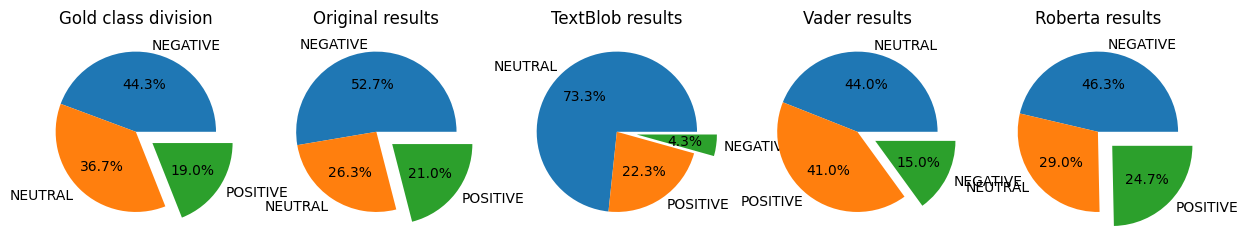

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

gold_class_counts = data_in_file['annotated_sentiment'].value_counts()

plt.figure(figsize=(15,7))

plt.subplot(1,5,1)
plt.title("Gold class division")
plt.pie(gold_class_counts.values, labels = gold_class_counts.index, explode = (0, 0, 0.25), autopct='%1.1f%%', shadow=False)

plt.subplot(1,5,2)
plt.title("Original results")
plt.pie(og_metrics[3].values, labels = og_metrics[3].index, explode = (0, 0, 0.25), autopct='%1.1f%%', shadow=False)

plt.subplot(1,5,3)
plt.title("TextBlob results")
plt.pie(textblob_metrics[3].values, labels = textblob_metrics[3].index, explode = (0, 0, 0.25), autopct='%1.1f%%', shadow=False)

plt.subplot(1,5,4)
plt.title("Vader results")
plt.pie(vader_metrics[3].values, labels = vader_metrics[3].index, explode = (0, 0, 0.25), autopct='%1.1f%%', shadow=False)

plt.subplot(1,5,5)
plt.title("Roberta results")
plt.pie(hf_roberta_metrics[3].values, labels = hf_roberta_metrics[3].index, explode = (0, 0, 0.25), autopct='%1.1f%%', shadow=False)

print()

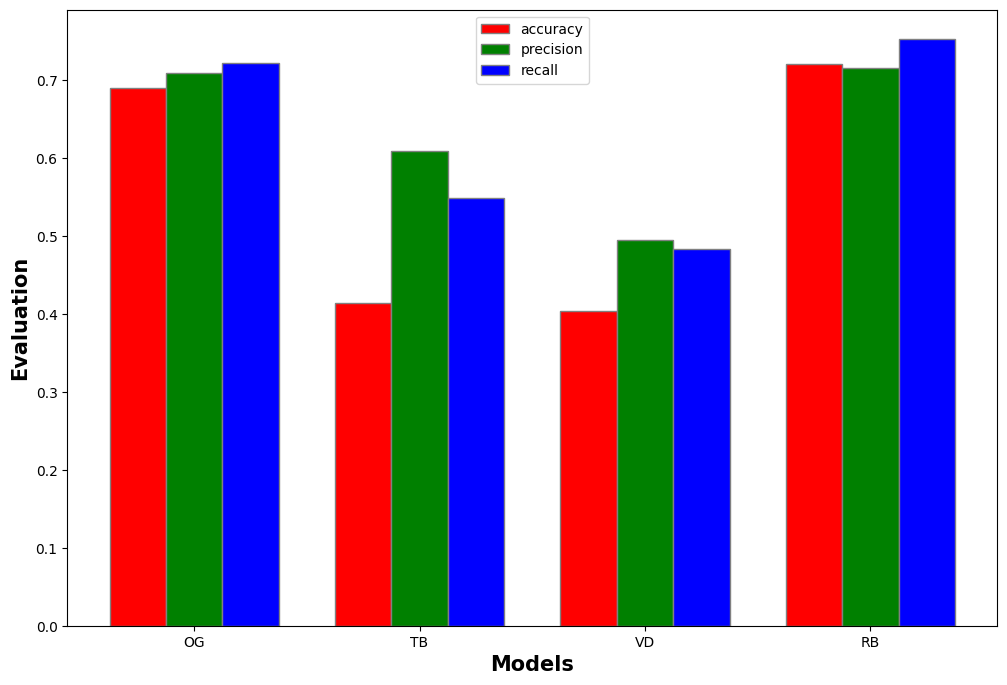

In [42]:
# Abbreviation
og = og_metrics
tb = textblob_metrics
vd = vader_metrics
hf = hf_roberta_metrics

# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
 
# set height of grouped metrics per class
accuracy = [og[0], tb[0], vd[0], hf[0]]
precision = [np.average(og[1]), np.average(tb[1]), np.average(vd[1]), np.average(hf[1])]
recall = [np.average(og[2]), np.average(tb[2]), np.average(vd[2]), np.average(hf[2])]

# Set position of bar on X axis
br1 = np.arange(len(accuracy))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, accuracy, color ='r', width = barWidth,
        edgecolor ='grey', label ='accuracy')
plt.bar(br2, precision, color ='g', width = barWidth,
        edgecolor ='grey', label ='precision')
plt.bar(br3, recall, color ='b', width = barWidth,
        edgecolor ='grey', label ='recall')
 
# Adding Xticks
plt.xlabel('Models', fontweight ='bold', fontsize = 15)
plt.ylabel('Evaluation', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(acc))],
        ['OG', 'TB', 'VD', 'RB'])
 
plt.legend()
plt.show()

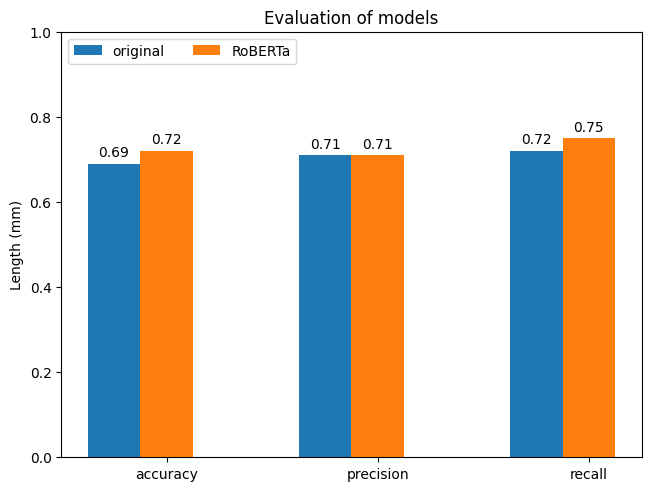

In [43]:
og = og_metrics
rb = hf_roberta_metrics

metrics = ("accuracy", "precision", "recall")

metrics_dict = {
        'original': (og[0], round(np.average(og[1]), 2), round(np.average(og[2]),2)),
        'RoBERTa': (rb[0], round(np.average(rb[1]), 2), round(np.average(rb[2]),2))
}

x = np.arange(len(metrics))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(constrained_layout=True)

for attribute, measurement in metrics_dict.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Length (mm)')
ax.set_title('Evaluation of models')
ax.set_xticks(x + width, metrics)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 1)

plt.show()